# Importing Libraries

In [1]:
import os
import sys
import random
import cv2


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.transforms import functional as TF

from PIL import Image, ImageFilter
import numpy as np
from sklearn.metrics import f1_score
from segmentation_models_pytorch import Unet
import matplotlib.pyplot as plt

# Setting GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Users\MSII\anaconda3\envs\Deep_Learning_Course\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

device(type='cuda')

# Creating the custom dataset

In [7]:
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, transform=None, is_test=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.is_test = is_test
        
        if is_test:
            # For test set, look for images in subdirectories
            self.images = []
            for test_dir in sorted(os.listdir(image_dir)):
                dir_path = os.path.join(image_dir, test_dir)
                if os.path.isdir(dir_path):
                    for img in os.listdir(dir_path):
                        if img.endswith(('.png', '.jpg', '.jpeg')):
                            self.images.append(os.path.join(test_dir, img))
        else:
            self.images = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        image = image.resize((416, 416))  
        
        if self.transform:
            image = self.transform(image)
            
        if self.is_test:
            return image, self.images[idx]  
        else:
            mask_path = os.path.join(self.mask_dir, self.images[idx])
            mask = Image.open(mask_path).convert('L')
            mask = mask.resize((416, 416))  
            mask = transforms.ToTensor()(mask)
            mask = (mask > 0.5).float()
            return image, mask

# Creating transformations, dataloaders

In [8]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

In [9]:
# Create training datasets
train_val_dataset = RoadSegmentationDataset(
    image_dir=r"C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\training\\images",
    mask_dir=r"C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\training\\groundtruth",
    transform=transform
)

# Create test dataset
test_dataset = RoadSegmentationDataset(
    image_dir=r"C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\test_set_images",
    transform=transform,
    is_test=True
)

In [10]:
# Use all data for training the GAN (no split needed since we have separate test dataset)
train_loader = DataLoader(train_val_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print(f"Training samples: {len(train_val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 100
Test samples: 50


# Applying data augmentation using Pix2Pix model
- Since the training sample size is small, we will apply data augmentation to increase the sample size
- to provide more robustness for real world applications

In [27]:
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        # Add size check 
        # If the spatial sizes of x and skip_input don’t match, resizes x to match skip_input
        if x.size(2) != skip_input.size(2) or x.size(3) != skip_input.size(3):
            x = F.interpolate(x, size=(skip_input.size(2), skip_input.size(3)))
        return torch.cat((x, skip_input), 1)

In [28]:
class Pix2PixGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.down1 = UNetDown(1, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)
        self.down6 = UNetDown(512, 512)
        
        # Decoder
        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 256, dropout=0.5)
        self.up4 = UNetUp(512, 128)
        self.up5 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, 3, 4, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)

        # Decoder
        u1 = self.up1(d6, d5)
        u2 = self.up2(u1, d4)
        u3 = self.up3(u2, d3)
        u4 = self.up4(u3, d2)
        u5 = self.up5(u4, d1)

        return self.final(u5)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #  input channels 4 (3 for real/fake image + 1 for mask)
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 4, stride=2, padding=1),  
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, padding=1)
            # Reducing the feature map depth to 1 channel, producing a single scalar output for each patch.
            # The discriminator evaluates each patch individually, as opposed to the entire image, making it a PatchGAN discriminator.
        )

    def forward(self, img_A, img_B):
        # img_A is the generated/real image (3 channels)
        # img_B is the mask (1 channel)
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [29]:
class RoadSegmentationGAN:
    def __init__(self):
        self.generator = Pix2PixGenerator().to(device)
        self.discriminator = Discriminator().to(device)
        self.criterion_GAN = nn.MSELoss()
        self.criterion_pixelwise = nn.L1Loss()
        self.lambda_pixel = 50  

    def train_gan(self, train_loader, num_epochs=3000):
        optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))  
        optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

        for epoch in range(num_epochs):
            epoch_d_loss = 0
            epoch_g_loss = 0
            num_batches = 0
            
            for i, (real_images, real_masks) in enumerate(train_loader):
                batch_size = real_images.size(0)
                real_images = real_images.to(device)
                real_masks = real_masks.to(device)

                if real_masks.dim() == 3:
                    real_masks = real_masks.unsqueeze(1)

                # Train Discriminator
                optimizer_D.zero_grad()
                fake_images = self.generator(real_masks)
                pred_fake = self.discriminator(fake_images.detach(), real_masks)
                loss_D_fake = self.criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
                pred_real = self.discriminator(real_images, real_masks)
                loss_D_real = self.criterion_GAN(pred_real, torch.ones_like(pred_real))
                loss_D = (loss_D_fake + loss_D_real) * 0.5
                loss_D.backward()
                optimizer_D.step()

                # Train Generator
                optimizer_G.zero_grad()
                pred_fake = self.discriminator(fake_images, real_masks)
                loss_G_GAN = self.criterion_GAN(pred_fake, torch.ones_like(pred_fake))
                loss_G_L1 = self.criterion_pixelwise(fake_images, real_images) * self.lambda_pixel
                loss_G = loss_G_GAN + loss_G_L1
                loss_G.backward()
                optimizer_G.step()

                epoch_d_loss += loss_D.item()
                epoch_g_loss += loss_G.item()
                num_batches += 1

            # Print average losses only every 10 epochs
            if (epoch + 1) % 10 == 0:
                avg_d_loss = epoch_d_loss / num_batches
                avg_g_loss = epoch_g_loss / num_batches
                print(f"Epoch [{epoch+1}/{num_epochs}] D loss: {avg_d_loss:.4f} G loss: {avg_g_loss:.4f}")

In [12]:
# Usage
gan = RoadSegmentationGAN()
print("Training Pix2Pix GAN...")
gan.train_gan(train_loader)

Training Pix2Pix GAN...
Epoch [10/3000] D loss: 0.0410 G loss: 31.0965
Epoch [20/3000] D loss: 0.0192 G loss: 27.3773
Epoch [30/3000] D loss: 0.0168 G loss: 24.7084
Epoch [40/3000] D loss: 0.0097 G loss: 23.4588
Epoch [50/3000] D loss: 0.0081 G loss: 22.6674
Epoch [60/3000] D loss: 0.0097 G loss: 21.9619
Epoch [70/3000] D loss: 0.0053 G loss: 21.3995
Epoch [80/3000] D loss: 0.0073 G loss: 21.0367
Epoch [90/3000] D loss: 0.0083 G loss: 20.6818
Epoch [100/3000] D loss: 0.0039 G loss: 20.3509
Epoch [110/3000] D loss: 0.0038 G loss: 20.1082
Epoch [120/3000] D loss: 0.0180 G loss: 19.8142
Epoch [130/3000] D loss: 0.0067 G loss: 19.6252
Epoch [140/3000] D loss: 0.0032 G loss: 19.4766
Epoch [150/3000] D loss: 0.0028 G loss: 19.3652
Epoch [160/3000] D loss: 0.0023 G loss: 19.1876
Epoch [170/3000] D loss: 0.0036 G loss: 19.0559
Epoch [180/3000] D loss: 0.0028 G loss: 18.8772
Epoch [190/3000] D loss: 0.0020 G loss: 18.7594
Epoch [200/3000] D loss: 0.0022 G loss: 18.6106
Epoch [210/3000] D loss: 

# Generate new samples

In [13]:
# Generate new samples using the trained GAN
def generate_new_samples(gan_model, train_loader, num_samples=1000):
    gan_model.generator.eval()
    new_images = []
    new_masks = []
    samples_generated = 0
    
    with torch.no_grad():
        while samples_generated < num_samples:
            for _, masks in train_loader:
                if samples_generated >= num_samples:
                    break
                    
                # Ensure masks have correct shape
                if masks.dim() == 3:
                    masks = masks.unsqueeze(1)
                masks = masks.to(device)
                
                # Generate fake images
                fake_images = gan_model.generator(masks)
                
                new_images.append(fake_images.cpu())
                new_masks.append(masks.cpu())
                
                samples_generated += masks.size(0)
                
    # Concatenate all generated samples
    new_images = torch.cat(new_images[:num_samples], dim=0)
    new_masks = torch.cat(new_masks[:num_samples], dim=0)
    
    return new_images, new_masks

print("Generating new samples...")
new_images, new_masks = generate_new_samples(gan, train_loader)
print(f"Generated {len(new_images)} new samples")

# the extra 3 generated images comes from that the 
# train_loader has a batch size of 4, and we've already generated 998 samples,
# the next batch will add 4 more samples, bringing the total to 1002 or 1003 (depending on the exact batch size).
# doesnt effect that much


Generating new samples...
Generated 1003 new samples


# Create a new class for the augmented dataset

In [27]:
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, new_images, new_masks):
        self.original_dataset = original_dataset
        self.new_images = new_images
        self.new_masks = new_masks

    def __len__(self):
        return len(self.original_dataset) + len(self.new_images)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            return self.original_dataset[idx]
        else:
            idx = idx - len(self.original_dataset)
            return self.new_images[idx], self.new_masks[idx]


augmented_dataset = AugmentedDataset(train_val_dataset, new_images, new_masks)
print("Original Dataset Size:", len(train_val_dataset))
print("Augmented Dataset Size:", len(augmented_dataset))

Original Dataset Size: 100
Augmented Dataset Size: 1103


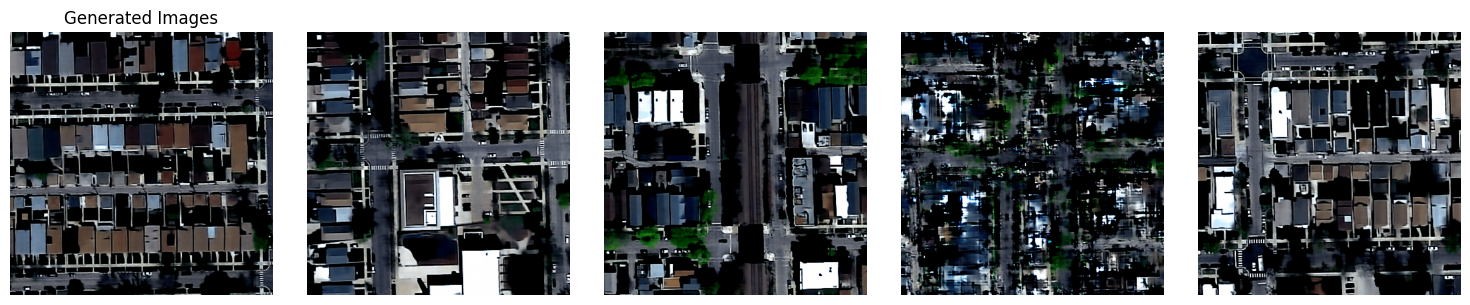

In [23]:
def visualize_generated_samples(generator, dataset, num_samples=5, figsize=(15, 3)):
    """
    Visualize only the generated images from the GAN
    
    """
    generator.eval()  # Set generator to evaluation mode
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    
    with torch.no_grad():
        for i in range(num_samples):
            idx = np.random.randint(len(dataset))
            _, mask = dataset[idx]
            
            # Ensure mask has correct dimensions
            if mask.dim() == 3:
                mask = mask.unsqueeze(0)
            else:
                mask = mask.unsqueeze(0).unsqueeze(0)
                
            # Generate image
            mask = mask.to(device)
            generated_image = generator(mask)
            
            # Convert to numpy and adjust format
            gen_img = generated_image.cpu().squeeze(0).numpy()
            gen_img = np.transpose(gen_img, (1, 2, 0))
            # Denormalize
            gen_img = (gen_img * 0.5 + 0.5).clip(0, 1)
            
            # Display
            axes[i].imshow(gen_img)
            axes[i].axis('off')
            if i == 0:
                axes[i].set_title('Generated Images')
    
    plt.tight_layout()
    plt.show()

visualize_generated_samples(gan.generator, train_val_dataset)

# Save the generated images and masks

In [28]:
def save_generated_samples(images, masks, image_dir, mask_dir):
    """
    Save generated images and masks to specified directories
    """
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)
    
    # Denormalize images
    denorm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    for idx, (image, mask) in enumerate(zip(images, masks)):
        # Denormalize and convert image to PIL
        image = denorm(image)
        image = torch.clamp(image, 0, 1)
        image_pil = transforms.ToPILImage()(image)
        
        # Convert mask to PIL
        mask_pil = transforms.ToPILImage()(mask.squeeze())
        
        # Save files
        image_path = os.path.join(image_dir, f'generated_image_{idx:04d}.png')
        mask_path = os.path.join(mask_dir, f'generated_image_{idx:04d}.png')
        
        image_pil.save(image_path)
        mask_pil.save(mask_path)
    
    print(f"Saved {len(images)} generated images and masks")

image_dir = r"C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\training\\images_generated"
mask_dir = r"C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\training\\groundtruth_generated"

save_generated_samples(new_images, new_masks, image_dir, mask_dir)

Saved 1003 generated images and masks


# Load the augmented dataset for use

In [11]:
class LoadAugmentedDataset(Dataset):
    def __init__(self, original_dataset, generated_image_dir, generated_mask_dir, transform=None):
        self.original_dataset = original_dataset
        self.transform = transform
        
        # Get list of generated images
        self.generated_images = sorted(os.listdir(generated_image_dir))
        self.generated_image_dir = generated_image_dir
        self.generated_mask_dir = generated_mask_dir

    def __len__(self):
        return len(self.original_dataset) + len(self.generated_images)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            return self.original_dataset[idx]
        else:
            # Load generated image and mask
            idx = idx - len(self.original_dataset)
            image_name = self.generated_images[idx]
            
            image_path = os.path.join(self.generated_image_dir, image_name)
            mask_path = os.path.join(self.generated_mask_dir, image_name)
            
            image = Image.open(image_path).convert('RGB')
            mask = Image.open(mask_path).convert('L')
            
            if self.transform:
                image = self.transform(image)
            
            mask = transforms.ToTensor()(mask)
            mask = (mask > 0.5).float()
            
            return image, mask

# Create the dataloaders after generating the new images

In [12]:
# Create the augmented dataset with both original and generated data
augmented_dataset = LoadAugmentedDataset(
    original_dataset=train_val_dataset,  
    generated_image_dir=r"C:\Users\MSII\Desktop\sanad_JU\Materials\Deep Learning\Project\training\images_generated",
    generated_mask_dir=r"C:\Users\MSII\Desktop\sanad_JU\Materials\Deep Learning\Project\training\groundtruth_generated",
    transform=transform
)

# Split the augmented dataset into train and validation
train_size = int(0.75 * len(augmented_dataset))
val_size = len(augmented_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(augmented_dataset, [train_size, val_size])

# Create new dataloaders with the augmented dataset (test_loader created at the beginning above)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [13]:
print(train_size)
print(val_size)

827
276


# Trial-3, 4:  Applying basic data augmentation
- The difference between these 2 trials is that the first trial we trained on 10 epochs, and we noticed that it can improve
- so we trained it again on 20 epochs, and it performed better.

In [17]:
def apply_basic_augmentation_in_place(combined_dataset):
    """
    Apply basic augmentation techniques to each sample in the combined dataset
    and replace the original samples with their augmented versions.
    """
    augmented_images = []
    augmented_masks = []
    
    # Define basic augmentation transforms
    basic_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(
            degrees=15,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1),
            fill=0
        ),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    ])
    
    normalize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    for idx in range(len(combined_dataset)):
        image, mask = combined_dataset[idx]
        
        # Convert tensor to PIL for augmentation
        image = transforms.ToPILImage()(image)
        mask = transforms.ToPILImage()(mask)
        
        # Apply same random transforms to both image and mask
        seed = torch.randint(0, 2**32, (1,))[0].item()
        
        # Apply transforms to image
        torch.manual_seed(seed)
        aug_image = basic_transforms(image)
        aug_image = normalize(aug_image)
        
        # Apply geometric transforms to mask
        torch.manual_seed(seed)
        aug_mask = basic_transforms(mask)
        aug_mask = transforms.ToTensor()(aug_mask)
        aug_mask = (aug_mask > 0.5).float()
        
        augmented_images.append(aug_image)
        augmented_masks.append(aug_mask)
        
        if (idx + 1) % 100 == 0:
            print(f"Processed {idx + 1}/{len(combined_dataset)} samples")
    
    augmented_images = torch.stack(augmented_images)
    augmented_masks = torch.stack(augmented_masks)
    
    return augmented_images, augmented_masks

In [18]:
class BasicAugmentedDataset(Dataset):
    def __init__(self, combined_dataset, basic_aug_images, basic_aug_masks):
        self.combined_dataset = combined_dataset  
        self.aug_images = basic_aug_images
        self.aug_masks = basic_aug_masks

    def __len__(self):
        return len(self.aug_images)  

    def __getitem__(self, idx):
        return self.aug_images[idx], self.aug_masks[idx]

In [16]:
print("Applying basic augmentation to all samples...")
aug_images, aug_masks = apply_basic_augmentation_in_place(augmented_dataset)

# Create new dataset with only the augmented versions
fully_augmented_dataset = BasicAugmentedDataset(augmented_dataset, aug_images, aug_masks)

print(f"Dataset size (after basic aug): {len(fully_augmented_dataset)}") 

Applying basic augmentation to all samples...
Processed 100/1103 samples
Processed 200/1103 samples
Processed 300/1103 samples
Processed 400/1103 samples
Processed 500/1103 samples
Processed 600/1103 samples
Processed 700/1103 samples
Processed 800/1103 samples
Processed 900/1103 samples
Processed 1000/1103 samples
Processed 1100/1103 samples
Dataset size (after basic aug): 1103


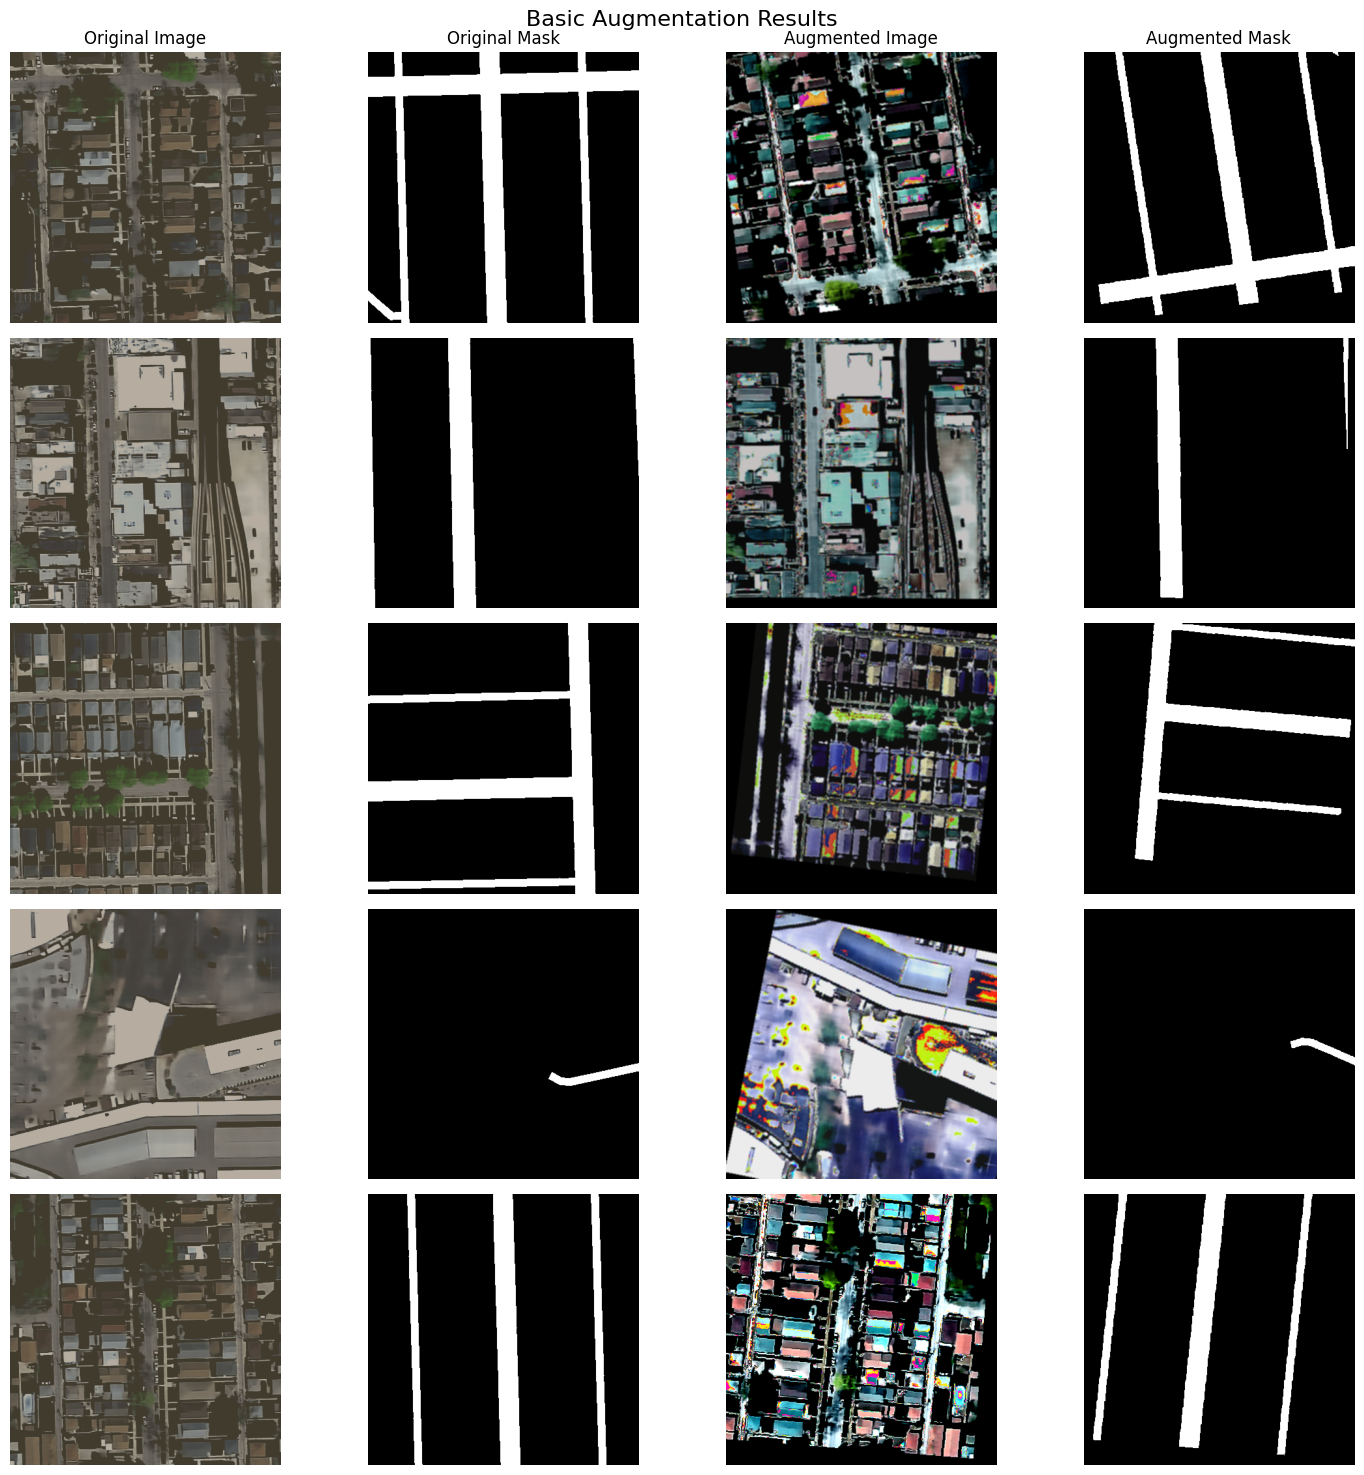

In [28]:
def visualize_augmentations(original_dataset, augmented_images, augmented_masks, num_samples=5):
    """
    Visualize original images and masks alongside their augmented versions
    """
    fig, axes = plt.subplots(num_samples, 4, figsize=(15, 3*num_samples))
    fig.suptitle('Basic Augmentation Results', fontsize=16)
    
    # Column labels
    axes[0, 0].set_title('Original Image')
    axes[0, 1].set_title('Original Mask')
    axes[0, 2].set_title('Augmented Image')
    axes[0, 3].set_title('Augmented Mask')
    
    # Randomly select samples to visualize
    indices = torch.randint(0, len(original_dataset), (num_samples,))
    
    for idx, sample_idx in enumerate(indices):
        # Get original image and mask
        orig_img, orig_mask = original_dataset[sample_idx]
        aug_img = augmented_images[sample_idx]
        aug_mask = augmented_masks[sample_idx]
        
        # Denormalize images
        denorm = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        
        orig_img = denorm(orig_img)
        aug_img = denorm(aug_img)
        
        # Convert to numpy arrays for plotting
        orig_img = orig_img.permute(1, 2, 0).numpy()
        orig_img = np.clip(orig_img, 0, 1)
        
        orig_mask = orig_mask.squeeze().numpy()
        
        aug_img = aug_img.permute(1, 2, 0).numpy()
        aug_img = np.clip(aug_img, 0, 1)
        
        aug_mask = aug_mask.squeeze().numpy()
        
        # Plot images
        axes[idx, 0].imshow(orig_img)
        axes[idx, 1].imshow(orig_mask, cmap='gray')
        axes[idx, 2].imshow(aug_img)
        axes[idx, 3].imshow(aug_mask, cmap='gray')
        
        # Remove axes
        for ax in axes[idx]:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_augmentations(augmented_dataset, aug_images, aug_masks, num_samples=5)

## Create dataloaders after applying basic augmentation

In [18]:
# Create the train/val split with the basic augmented dataset
train_size = int(0.75 * len(fully_augmented_dataset))
val_size = len(fully_augmented_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(fully_augmented_dataset, [train_size, val_size])

# Create new dataloaders with the basic augmented data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")

Training samples: 827
Validation samples: 276


## Training on basic augmentation data

In [19]:
# Train model with fully augmented data
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20
val_f1, history = train_model_and_f1_score(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/20] Train Loss: 0.6405, Val Loss: 0.5783, Val F1: 0.6007
Epoch [2/20] Train Loss: 0.4329, Val Loss: 0.3856, Val F1: 0.7705
Epoch [3/20] Train Loss: 0.3419, Val Loss: 0.3222, Val F1: 0.8208
Epoch [4/20] Train Loss: 0.2913, Val Loss: 0.2802, Val F1: 0.8466
Epoch [5/20] Train Loss: 0.2546, Val Loss: 0.2539, Val F1: 0.8626
Epoch [6/20] Train Loss: 0.2281, Val Loss: 0.2338, Val F1: 0.8711
Epoch [7/20] Train Loss: 0.2075, Val Loss: 0.2197, Val F1: 0.8791
Epoch [8/20] Train Loss: 0.1899, Val Loss: 0.2034, Val F1: 0.8854
Epoch [9/20] Train Loss: 0.1742, Val Loss: 0.1917, Val F1: 0.8905
Epoch [10/20] Train Loss: 0.1605, Val Loss: 0.1803, Val F1: 0.8929
Epoch [11/20] Train Loss: 0.1489, Val Loss: 0.1707, Val F1: 0.8963
Epoch [12/20] Train Loss: 0.1395, Val Loss: 0.1664, Val F1: 0.8969
Epoch [13/20] Train Loss: 0.1301, Val Loss: 0.1547, Val F1: 0.9016
Epoch [14/20] Train Loss: 0.1217, Val Loss: 0.1521, Val F1: 0.8982
Epoch [15/20] Train Loss: 0.1148, Val Loss: 0.1415, Val F1: 0.9047
Epoc

## Testing and evaluating F1-score on basic augmentation

In [20]:
# Test the model
f1_scores = test_model_f1_scores(model, test_loader, 
                                 output_dir='C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\Predictions_20epochs_basic')
print(f'Min F1 Score: {min(f1_scores):.4f}')
print(f'Max F1 Score: {max(f1_scores):.4f}')

Completed predictions for 50 test images
Min F1 Score: 0.9286
Max F1 Score: 0.9792


# Trial-5: Applying advanced data augmentation techniques in combination with the basic ones
## We will use 2 new techniques in combination with the basic ones above
- <p style="font-size:14px;"><strong>Elastic transformation:</strong> Apply random elastic distortions to mimic deformations caused by terrain or lens effects, enhancing robustness to irregular road shapes.</p>
- <p style="font-size:14px;"><strong>Shadow/cloud overlays:</strong> Simulate shadows or clouds as semi-transparent layers to improve generalization for real-world satellite imagery conditions.</p>

## Define class for each technique

In [108]:
class ElasticTransform:
    def __init__(self, alpha=100, sigma=10):  
        self.alpha = alpha
        self.sigma = sigma
        
    def __call__(self, img, mask):
        """Apply elastic transformation to image and mask"""
        # Convert to numpy arrays
        img_np = np.array(img)
        mask_np = np.array(mask)
        
        # Generate random displacement fields
        dx = np.random.rand(416, 416) * 2 - 1
        dy = np.random.rand(416, 416) * 2 - 1
        
        # Gaussian filter the displacement fields
        dx = cv2.GaussianBlur(dx, (0, 0), self.sigma) * self.alpha
        dy = cv2.GaussianBlur(dy, (0, 0), self.sigma) * self.alpha
        
        # Create meshgrid
        x, y = np.meshgrid(np.arange(416), np.arange(416))
        
        # Add displacement to the meshgrid
        map_x = (x + dx).astype(np.float32)
        map_y = (y + dy).astype(np.float32)
        
        # Apply transformation
        img_warped = cv2.remap(img_np, map_x, map_y, cv2.INTER_LINEAR)
        mask_warped = cv2.remap(mask_np, map_x, map_y, cv2.INTER_NEAREST)
        
        # Ensure mask is 2D and convert to uint8
        if mask_warped.ndim == 3:
            mask_warped = mask_warped[:, :, 0]
        mask_warped = (mask_warped * 255).astype(np.uint8)
        
        return Image.fromarray(img_warped), Image.fromarray(mask_warped)

class RandomShadowCloud:
    def __init__(self, shadow_prob=0.3, cloud_prob=0.3):  
        self.shadow_prob = shadow_prob
        self.cloud_prob = cloud_prob
        
    def apply_shadow(self, img):
        """Apply random shadow to image"""
        img_np = np.array(img)
        h, w = img_np.shape[:2]
        
        # Create random polygon for shadow
        vertices = np.array([
            [np.random.randint(0, w), 0],
            [np.random.randint(0, w), h],
            [np.random.randint(0, w), np.random.randint(0, h)]
        ], dtype=np.int32)
        
        # Create mask for shadow
        mask = np.zeros_like(img_np[:,:,0])
        cv2.fillPoly(mask, [vertices], 1)
        
        # Apply shadow with less intensity
        alpha = random.uniform(0.7, 0.9)  # Lighter shadows
        img_np[mask == 1] = img_np[mask == 1] * alpha
        
        return Image.fromarray(img_np)
    
    def apply_cloud(self, img):
        """Apply cloud effect to image with reduced intensity"""
        img_np = np.array(img)
    
        # Create subtle cloud pattern with reduced noise range
        cloud = np.random.normal(0.95, 0.02, (416//4, 416//4))  # Lower standard deviation for less noise
        cloud = cv2.resize(cloud, (416, 416))
        cloud = np.clip(cloud, 0.9, 1.0)  # Clamp cloud values to a narrower range for less impact
    
        # Apply cloud with reduced intensity
        alpha = random.uniform(0.05, 0.1)  
        img_np = img_np * (1 - alpha * cloud[..., np.newaxis])
        img_np = np.clip(img_np, 0, 255).astype(np.uint8)
    
        return Image.fromarray(img_np)

    
    def __call__(self, img, mask):
        if random.random() < self.shadow_prob:
            img = self.apply_shadow(img)
        if random.random() < self.cloud_prob:
            img = self.apply_cloud(img)
        return img, mask

## Applying all augmentation techniques in a function

In [109]:
def apply_combined_augmentation_in_place(combined_dataset):
    """
    Apply both basic and advanced augmentation techniques to the dataset
    """
    augmented_images = []
    augmented_masks = []
    
    # Define basic transforms
    basic_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.RandomAffine(
            degrees=15,
            translate=(0.1, 0.1),
            scale=(0.95, 1.05),
            fill=0
        ),
    ])
    
    # Create instances of advanced transforms
    elastic_transform = ElasticTransform(alpha=100, sigma=10)
    shadow_cloud = RandomShadowCloud(shadow_prob=0.3, cloud_prob=0.3)
    
    # Normalize transform
    normalize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    for idx in range(len(combined_dataset)):
        image, mask = combined_dataset[idx]
        
        # Convert tensor to PIL for augmentation
        image = transforms.ToPILImage()(image)
        mask = transforms.ToPILImage()(mask)
        
        # Apply basic augmentations
        seed = torch.randint(0, 2**32, (1,))[0].item()
        torch.manual_seed(seed)
        image = basic_transforms(image)
        torch.manual_seed(seed)
        mask = basic_transforms(mask)
        
        # Apply advanced augmentations one by one
        image, mask = elastic_transform(image, mask)
        image, mask = shadow_cloud(image, mask)
        
        # Convert back to tensor and normalize
        image = normalize(image)
        mask = transforms.ToTensor()(mask)
        mask = (mask > 0.5).float()
        
        augmented_images.append(image)
        augmented_masks.append(mask)
        
        if (idx + 1) % 100 == 0:
            print(f"Processed {idx + 1}/{len(combined_dataset)} samples")
    
    return torch.stack(augmented_images), torch.stack(augmented_masks)

In [110]:
print("Applying advanced augmentation to all samples...")
adv_aug_images, adv_aug_masks = apply_combined_augmentation_in_place(augmented_dataset)

Applying advanced augmentation to all samples...
Processed 100/1103 samples
Processed 200/1103 samples
Processed 300/1103 samples
Processed 400/1103 samples
Processed 500/1103 samples
Processed 600/1103 samples
Processed 700/1103 samples
Processed 800/1103 samples
Processed 900/1103 samples
Processed 1000/1103 samples
Processed 1100/1103 samples


## Let's see the effect on the images

In [111]:
def visualize_augmentation_types(dataset, num_samples=3):
    """
    Visualize the effect of each type of augmentation separately
    """
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))  # Changed from 6 to 5 columns
    fig.suptitle('Augmentation Effects', fontsize=16)
    
    # Column labels
    axes[0, 0].set_title('Original')
    axes[0, 1].set_title('Basic Aug')
    axes[0, 2].set_title('Elastic')
    axes[0, 3].set_title('Shadow/Cloud')
    axes[0, 4].set_title('All Combined')
    
    # Get samples
    indices = torch.randint(0, len(dataset), (num_samples,))
    
    # Define denormalization transform
    denorm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    for row, idx in enumerate(indices):
        image, mask = dataset[idx]
        
        # Denormalize the original image
        orig_image = denorm(image.clone())
        orig_image = torch.clamp(orig_image, 0, 1)
        orig_image = transforms.ToPILImage()(orig_image)
        
        # Convert to PIL for augmentations
        image = transforms.ToPILImage()(image)
        
        # Original
        axes[row, 0].imshow(orig_image)
        
        # Basic augmentation
        basic_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomAffine(
                degrees=10,
                translate=(0.05, 0.05),
                scale=(0.95, 1.05),
                fill=0
            )
        ])
        basic_aug = basic_transforms(image)
        axes[row, 1].imshow(basic_aug)
        
        # Elastic transformation
        elastic = ElasticTransform()(image, mask)[0]
        axes[row, 2].imshow(elastic)
        
        # Shadow/Cloud
        shadow_cloud = RandomShadowCloud()(image, mask)[0]
        axes[row, 3].imshow(shadow_cloud)
        
        # All combined 
        combined = image
        for transform in [basic_transforms, ElasticTransform(), RandomShadowCloud()]:
            if isinstance(transform, transforms.Compose):
                combined = transform(combined)
            else:
                combined = transform(combined, mask)[0]
        axes[row, 4].imshow(combined)
        
        # Remove axes
        for ax in axes[row]:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

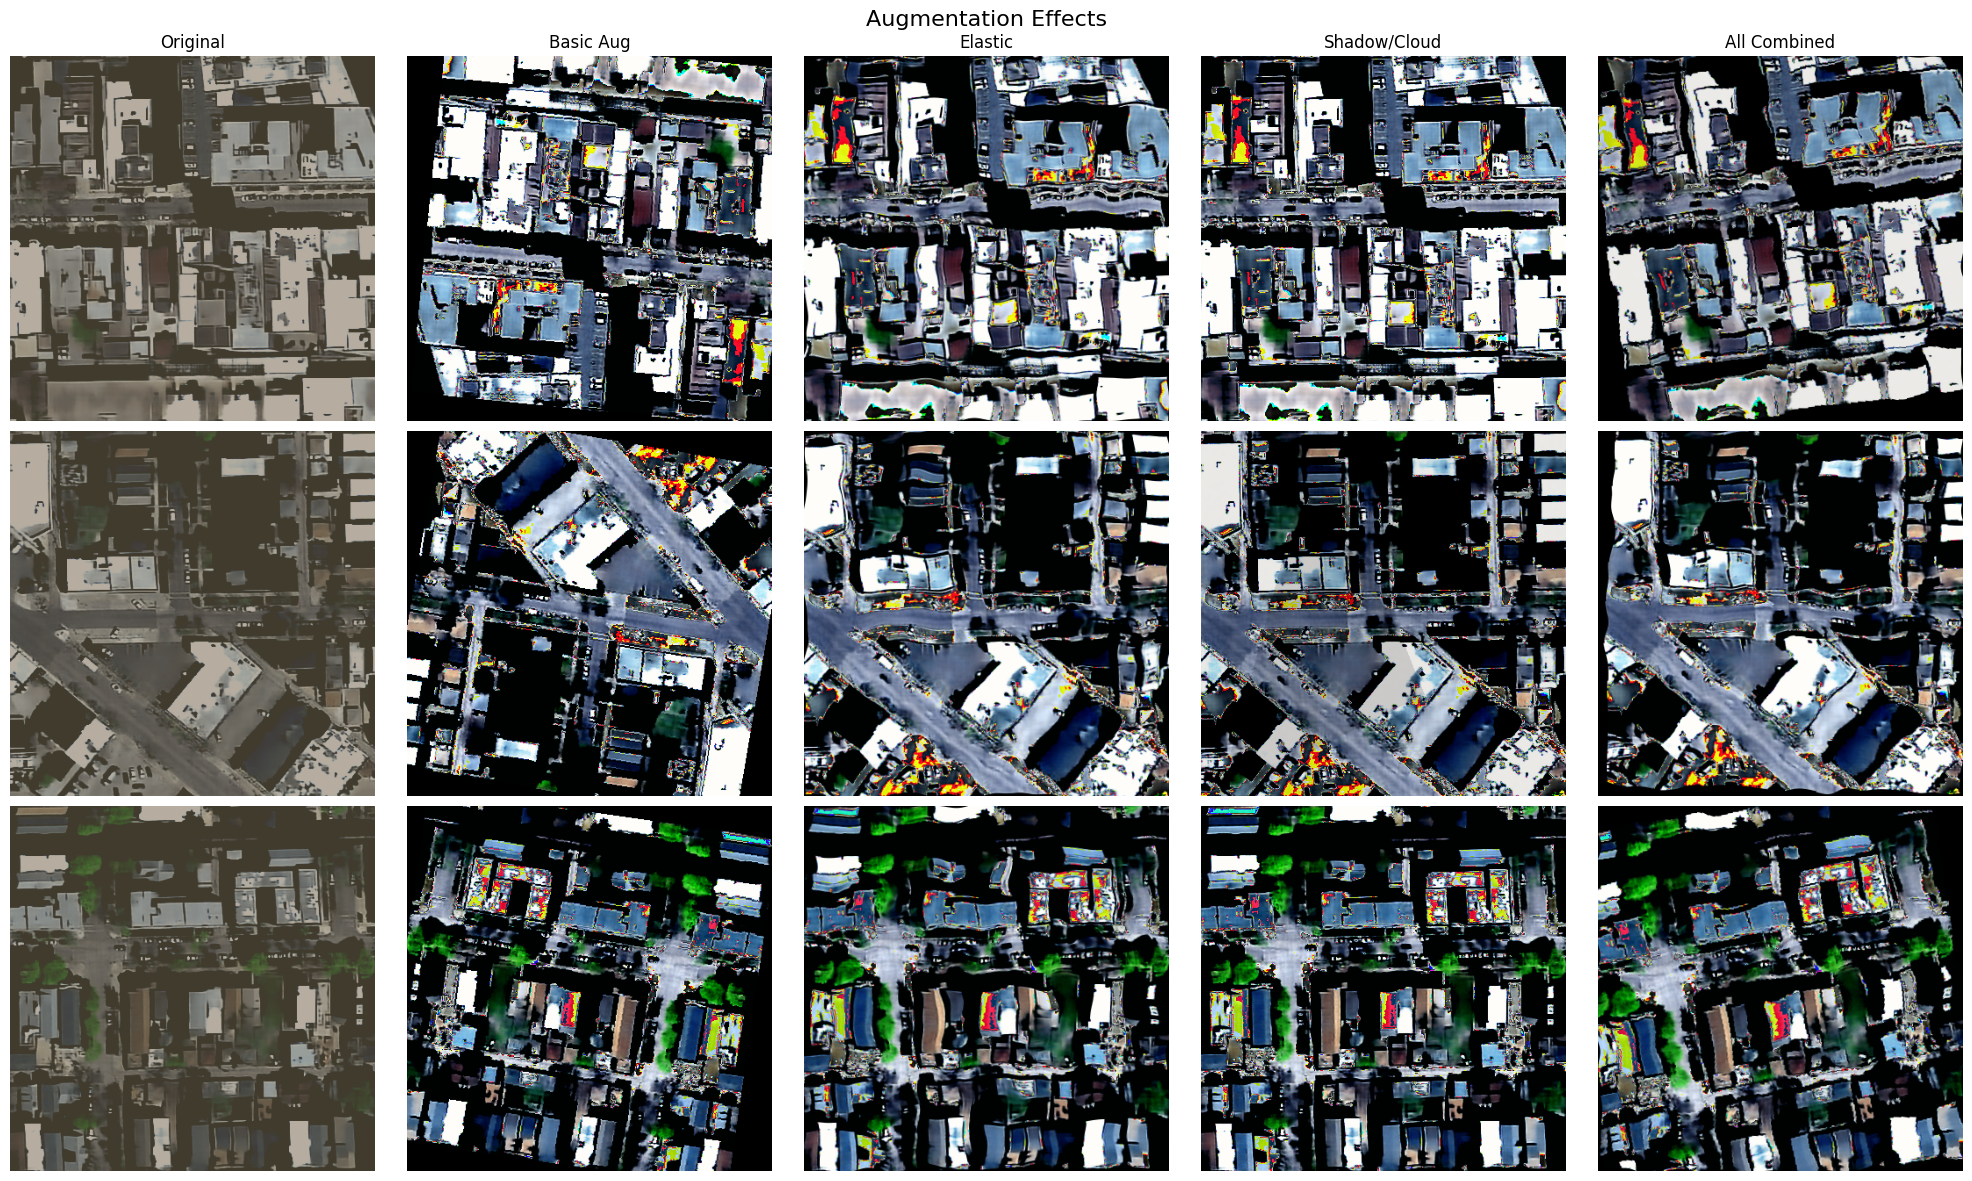

In [114]:
visualize_augmentation_types(augmented_dataset, num_samples=3)

## Let's create the new dataset 

In [121]:
class AdvancedAugmentedDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images  
        self.masks = masks    

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]

In [124]:
advanced_augmented_dataset = AdvancedAugmentedDataset(adv_aug_images, adv_aug_masks)

# Split into train and validation
train_size = int(0.75 * len(advanced_augmented_dataset))
val_size = len(advanced_augmented_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    advanced_augmented_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 827
Validation samples: 276
Test samples: 50


## Training on the full augmentation techniques

In [125]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20
val_f1, history = train_model_and_f1_score(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/20] Train Loss: 0.6535, Val Loss: 0.5581, Val F1: 0.2068
Epoch [2/20] Train Loss: 0.4863, Val Loss: 0.3908, Val F1: 0.7513
Epoch [3/20] Train Loss: 0.3772, Val Loss: 0.3615, Val F1: 0.6802
Epoch [4/20] Train Loss: 0.3283, Val Loss: 0.4844, Val F1: 0.6399
Epoch [5/20] Train Loss: 0.2748, Val Loss: 0.2979, Val F1: 0.8175
Epoch [6/20] Train Loss: 0.2157, Val Loss: 0.2678, Val F1: 0.7777
Epoch [7/20] Train Loss: 0.1920, Val Loss: 0.3893, Val F1: 0.5037
Epoch [8/20] Train Loss: 0.2073, Val Loss: 0.2589, Val F1: 0.7945
Epoch [9/20] Train Loss: 0.1416, Val Loss: 0.2480, Val F1: 0.8257
Epoch [10/20] Train Loss: 0.1380, Val Loss: 0.4559, Val F1: 0.6758
Epoch [11/20] Train Loss: 0.1922, Val Loss: 0.2513, Val F1: 0.7740
Epoch [12/20] Train Loss: 0.1455, Val Loss: 0.4118, Val F1: 0.7157
Epoch [13/20] Train Loss: 0.1483, Val Loss: 0.2921, Val F1: 0.7811
Epoch [14/20] Train Loss: 0.0944, Val Loss: 0.2392, Val F1: 0.8253
Epoch [15/20] Train Loss: 0.1322, Val Loss: 0.2910, Val F1: 0.7968
Epoc

In [127]:
def test_model_f1_scores(model, test_loader, output_dir='C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\Predictions'):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    test_f1_scores = []
    
    with torch.no_grad():
        for images, image_names in test_loader:
            images = images.to(device)
            
            # Generate predictions
            outputs = model(images)
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            
            # Calculate F1 score
            batch_f1 = f1_score(predictions.cpu().numpy().flatten(), 
                              outputs.cpu().numpy().flatten() > 0.5)
            test_f1_scores.append(batch_f1)
            
            # Save predictions
            for pred, name in zip(predictions, image_names):
                
                pred_img = ((1 - pred.cpu().numpy()[0]) * 255).astype(np.uint8)  # Added 1 - pred to invert mask values
                pred_img = Image.fromarray(pred_img)
                pred_img = pred_img.resize((400, 400))
                
                # Create directory and save
                test_num = name.split(os.sep)[0]
                os.makedirs(os.path.join(output_dir, test_num), exist_ok=True)
                save_path = os.path.join(output_dir, test_num, 'prediction.png')
                pred_img.save(save_path)
    
    print(f"Completed predictions for {len(test_loader.dataset)} test images")
    return test_f1_scores

In [128]:
# Test the model
f1_scores = test_model_f1_scores(model, test_loader, 
                                 output_dir='C:\\Users\\MSII\\Desktop\\sanad_JU\\Materials\\Deep Learning\\Project\\Predictions_20epochs_fullAug')
print(f'Min F1 Score: {min(f1_scores):.4f}')
print(f'Max F1 Score: {max(f1_scores):.4f}')

Completed predictions for 50 test images
Min F1 Score: 0.9578
Max F1 Score: 0.9929


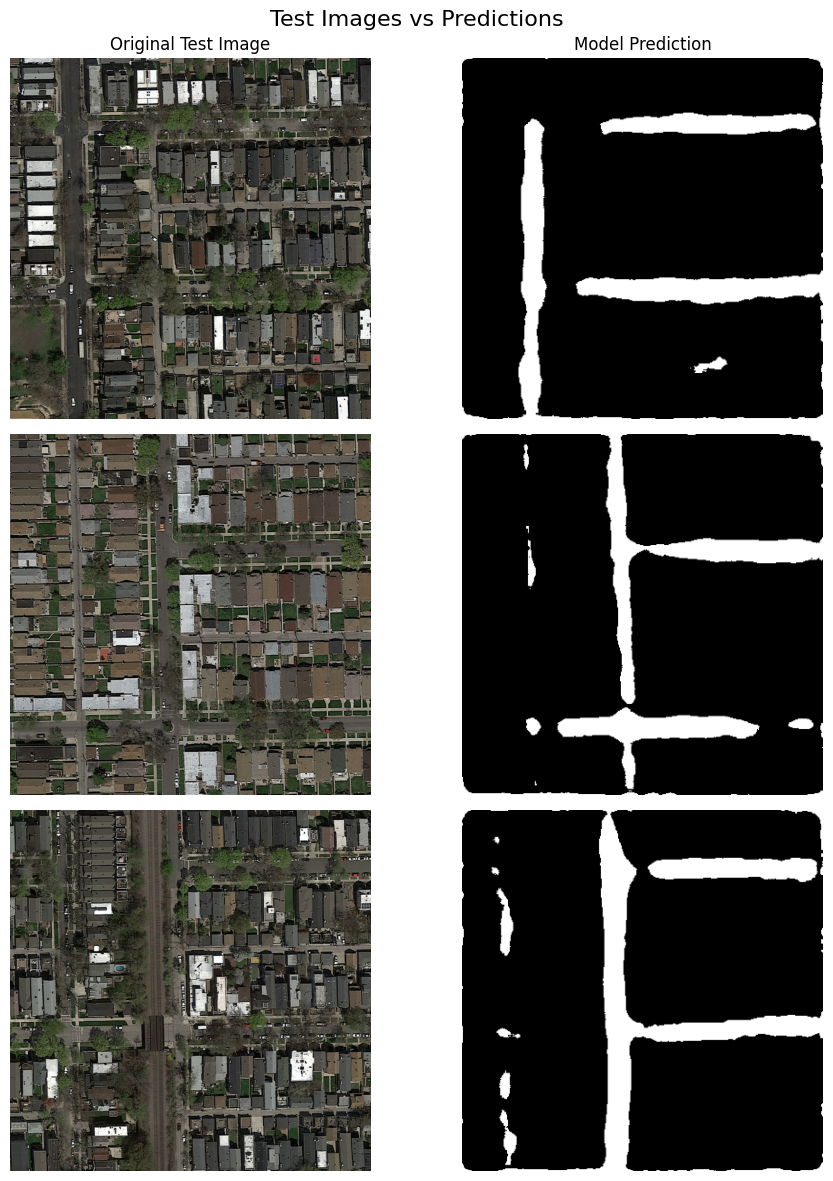

In [163]:
def visualize_test_predictions(test_dir, pred_dir, num_samples=5):
    """
    Visualize test images with their corresponding predictions
    
    Args:
        test_dir: Directory containing test folders (test_1 to test_50)
        pred_dir: Directory containing prediction folders
        num_samples: Number of samples to visualize
    """
    # Get list of test folders
    test_folders = sorted([f for f in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, f))])
    
    # Randomly select samples
    if num_samples > len(test_folders):
        num_samples = len(test_folders)
    selected_folders = random.sample(test_folders, num_samples)
    
    # Create subplot
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    fig.suptitle('Test Images vs Predictions', fontsize=16)
    
    # Set column labels
    axes[0, 0].set_title('Original Test Image')
    axes[0, 1].set_title('Model Prediction')
    
    for idx, folder in enumerate(selected_folders):
        # Load test image
        test_img_path = os.path.join(test_dir, folder, f"{folder}.png")
        test_img = Image.open(test_img_path)
        
        # Load prediction
        pred_path = os.path.join(pred_dir, folder, "prediction.png")
        pred_img = Image.open(pred_path)
        
        # Display images
        axes[idx, 0].imshow(test_img)
        axes[idx, 1].imshow(pred_img, cmap='gray')
        
        # Remove axes
        axes[idx, 0].axis('off')
        axes[idx, 1].axis('off')
        
        # Add folder number as label
        axes[idx, 0].set_ylabel(f'{folder}', fontsize=12)
    
    plt.tight_layout()
    plt.show()

test_dir = r"C:\Users\MSII\Desktop\sanad_JU\Materials\Deep Learning\Project\test_set_images"
pred_dir = r"C:\Users\MSII\Desktop\sanad_JU\Materials\Deep Learning\Project\Predictions_20epochs_fullAug"

visualize_test_predictions(test_dir, pred_dir, num_samples=3)